In [1]:
%matplotlib inline


# Fitting the xG model

In this page we go through all the steps of statistically fitting
an expected goals model.

Before starting watch the following two videos from Friends of Tracking.

..  youtube:: bpjLyFyLlXs
   :width: 640
   :height: 349

You will be sad to learn that Tobias (the dog featuring in
this video) died suddenly during summer 2022 :-(

..  youtube:: wHOgINJ5g54
   :width: 640
   :height: 349

These use an older version of the code, which is available
[here](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython).
But the steps are the same.


In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings 

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Opening data
To fit the xG model we will use Wyscout data. To meet file size requirements of Github, we have to open it from different files,
but you can open the file locally from the directory you saved it in.



In [17]:
#load data - store it in train dataframe
train = pd.DataFrame()
for i in range(13):
    file_name = 'events_England' + str(i+1) + '.json'
    path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', file_name)
    with open('events_England.json') as f:
        data = json.load(f)
    train = pd.concat([train, pd.DataFrame(data)])

In [22]:
train.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


## Preparing  data
Exepcted goals model is build using only shots, so we keep only those actions which *subEventName* was *Shot*. Note that this way
penalties are excluded which wouldn't be a case if we used only *eventName*. Then, we store the coordinates of a shot transformed
to 105 x 68 pitch. Also, we treat the goal as x = 0. Created *C* is an auxillary variable to help us calculate distance and angle.
It is the distance from a point to the vertical line through the middle of the pitch. We calculate the distance to the goal as the
distance on Euclidean plane (see [Distance in R2](https://www.youtube.com/watch?v=Qkpr30zSpiE&t=297s&ab_channel=FriendsofTracking)).
and angle using the formula from [The Geometry of Shooting](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760).
Moreover, we need an information if a goal was scored. It can be found in the *tags* column - if in this column exists {*id*: *101*}.



In [23]:
shots = train.loc[train['subEventName'] == 'Shot']

#get shot coordinates as separate columns
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)

#calculate distance and angle 
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)

#if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object 
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)

In [28]:
print(shots["Goal"])

46        1
62        0
91        1
128       0
249       0
         ..
642945    0
643023    1
643051    0
643055    0
643149    0
Name: Goal, Length: 109863, dtype: object


## Plotting shot location
Since we would like to investigate the relationship between shot location and goal location, first we create a heat map of all 
shots from the 2017/18 Premier League season.



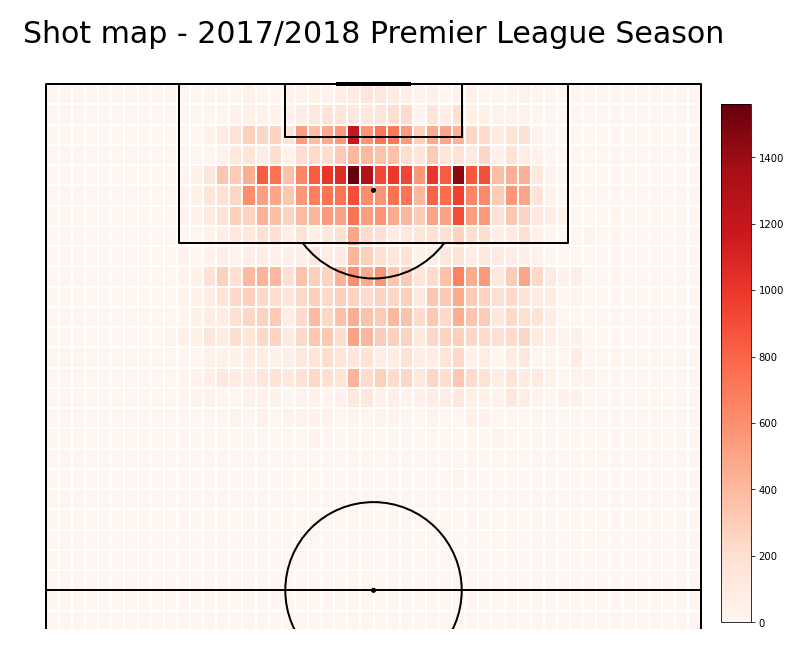

In [29]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#subtracting x from 105 but not y from 68 because of inverted Wyscout axis
#calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)
#make heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

## Plotting goal location
Having the shot location, we would also like to know where the goals were scored from.



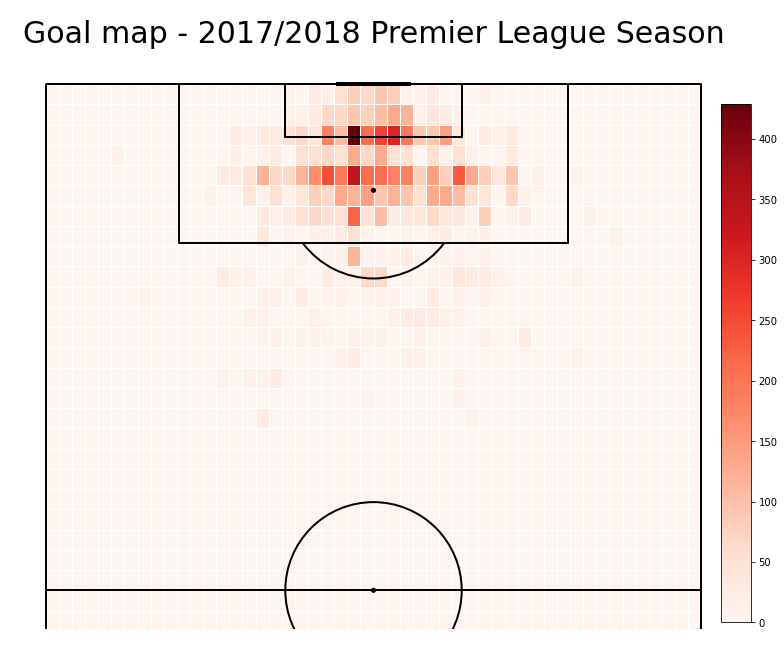

In [30]:
#take only goals
goals = shots.loc[shots["Goal"] == 1]

#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#calculate number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)
#plot heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

## Plotting the probability of scoring a goal given the location
Now, we can calculate the proportion of goals scored from each bin to number of shots from that location. 



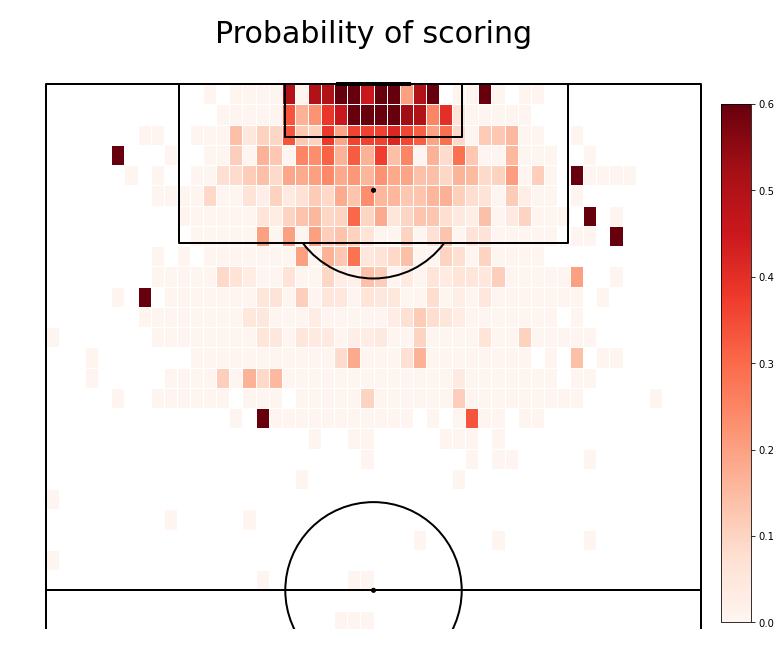

In [31]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic = pitch.bin_statistic(105 - shots.X, shots.Y, bins = 50)

#normalize number of goals by number of shots 
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]
#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of scoring' , fontsize = 30)
plt.show()

## Plotting a logistic curve
Plotting logistic curve



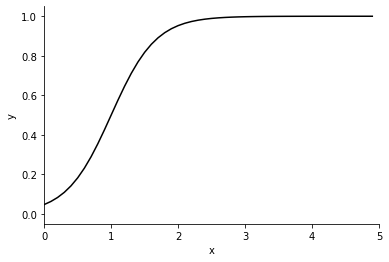

In [32]:
b = [3, -3]
x = np.arange(5, step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x))
fig,ax = plt.subplots()
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x") 
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Investigating the relationship between goals and angle
We want to find out if the angle influences scoring a goal. First we plot if goal was scored given
the angle.



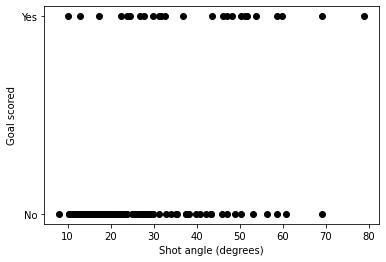

In [33]:
#first 200 shots
shots_200=shots.iloc[:200]

#plot first 200 shots goal angle
fig, ax = plt.subplots()
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markersize= 12, color='black')

#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

## Investigating the relationship between probability of scoring goals and angle
We want to find out if the angle influences the probability of scoring a goal. First we plot if goal was scored given
the angle.



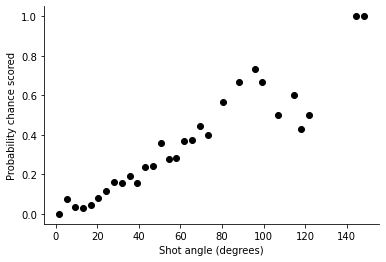

In [34]:
#number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])
#number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')

#probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2

#make plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Fitting logistic regression with random coefficients
To our data we fit a logistic regression curve with set parameters - 3 for intercept and -3 for angle. However, these are most likely
not the best estimators of true parameters. 



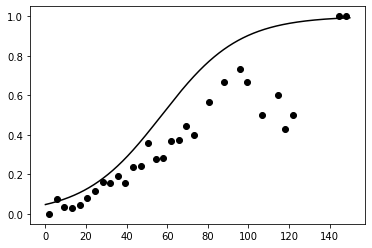

In [35]:
fig, ax = plt.subplots()
b = [3, -3]
x = np.arange(150,step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180)) 
#plot line
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

## Calculating log-likelihood
The best parameters are those which maximize the log-likelihood.



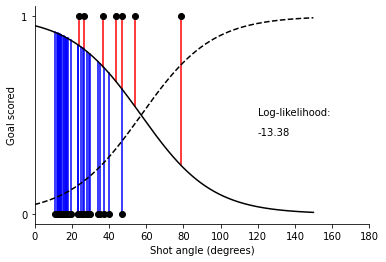

In [45]:
#calculate xG
xG = 1/(1+np.exp(b[0]+b[1]*shots['Angle'])) 
shots = shots.assign(xG = xG)
shots_40 = shots.iloc[:40]
fig, ax = plt.subplots()

#plot data
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', markersize= 12, color='black', zorder = 3)

#plot curves
ax.plot(x, y, linestyle='--', color='black', zorder = 2)
ax.plot(x, 1-y, linestyle='solid', color='black', zorder = 2)

#calculate loglikelihood
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang = shot['Angle'] * 180/np.pi
    if shot['Goal'] == 1:
        loglikelihood = loglikelihood + np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='red', zorder = 1)
    else:
        loglikelihood = loglikelihood + np.log(1 - shot['xG'])
        ax.plot([ang,ang], [shot['Goal'], 1-shot['xG']], color='blue', zorder = 1) 

#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,180))
plt.text(120,0.5,'Log-likelihood:') 
plt.text(120,0.4,str(loglikelihood)[:6])
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Fitting logistic regression and finding best parameters
The best parameters are those which maximize the log-likelihood.



In [46]:
#create model
test_model = smf.glm(formula="Goal ~ Angle" , data=shots, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:               109863
Model:                                GLM   Df Residuals:                   109861
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -33296.
Date:                    Wed, 14 Sep 2022   Deviance:                       66592.
Time:                            17:36:16   Pearson chi2:                 1.04e+05
No. Iterations:                         6   Pseudo R-squ. (CS):            0.07609
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

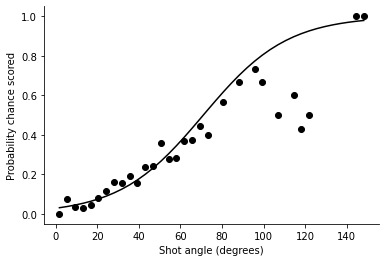

In [47]:
#get params        
b=test_model.params

#calculate xG
xGprob = 1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
fig, ax = plt.subplots()

#plot data
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')

#plot line
ax.plot(midangle, xGprob, linestyle='solid', color='black')

#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Investigating the relationship between probability of scoring goals and distance to goal 
We want to find out if the distanse influences the probability of scoring a goal. First we plot the probability of scoring given
the distance. Then, we fit logistic regression to the data.



                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:               109863
Model:                                GLM   Df Residuals:                   109861
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -32818.
Date:                    Wed, 14 Sep 2022   Deviance:                       65635.
Time:                            17:54:22   Pearson chi2:                 2.03e+05
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08410
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

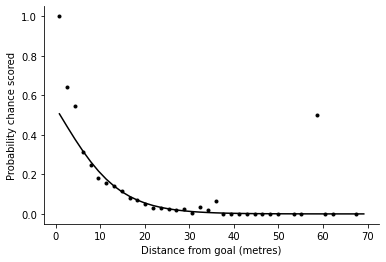

In [55]:
#number of shots
shotcount_dist = np.histogram(shots['Distance'],bins=40,range=[0, 70])

#number of goals
goalcount_dist = np.histogram(goals['Distance'],bins=40,range=[0, 70])

#empirical probability of scoring
prob_goal = np.divide(goalcount_dist[0],shotcount_dist[0])
distance = shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2

#making a plot
fig, ax = plt.subplots()
#plotting data
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')

#making legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
##plt.show()
#make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots, 
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())        
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
#plot line
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

## Adding squared distance to the model
To our model we can add more variables than only one. We can try adding distance to goal squared and see if it improves
our predictions.



In [50]:
#calculating distance squared
shots["D2"] = shots['Distance']**2

#adding it to the model
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots, 
                           family=sm.families.Binomial()).fit()
#print model summary
print(test_model.summary()) 

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:               109863
Model:                                GLM   Df Residuals:                   109860
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -32572.
Date:                    Wed, 14 Sep 2022   Deviance:                       65145.
Time:                            17:50:10   Pearson chi2:                 1.10e+05
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08818
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

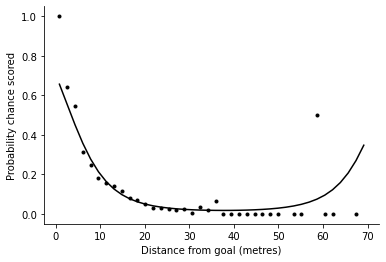

In [51]:
#get parameters       
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2))) 
fig, ax = plt.subplots()
#plot line
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

## Adding squared distance to the model
To our model we can add more variables than only one. We can try adding distance to goal squared and see if it improves
our predictions.



                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:               109863
Model:                                GLM   Df Residuals:                   109855
Model Family:                    Binomial   Df Model:                            7
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -32483.
Date:                    Wed, 14 Sep 2022   Deviance:                       64966.
Time:                            17:55:28   Pearson chi2:                 1.09e+05
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08966
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

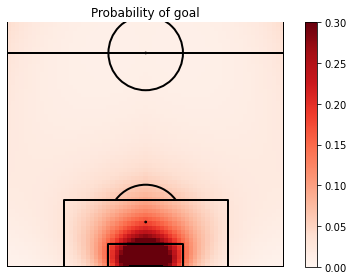

In [56]:
#creating extra variables
shots["X2"] = shots['X']**2
shots["C2"] = shots['C']**2
shots["AX"]  = shots['Angle']*shots['X']

# list the model variables you want here
model_variables = ['Angle','Distance','X','C', "X2", "C2", "AX"]
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots, 
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())        
b=test_model.params

#return xG value for more general model
def calculate_xG(sh):    
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum)) 
   return xG   

#add an xG to my dataframe
xG=shots.apply(calculate_xG, axis=1) 
shots = shots.assign(xG=xG)

#Create a 2D map of xG
pgoal_2d=np.zeros((68,68))
for x in range(68):
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['D2'] = x**2 + abs(y-68/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-68/2)
        sh['C2'] = (y-68/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.draw()
#plot probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder = 1)
fig.colorbar(pos, ax=ax)
#make legend
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Testing model fit
Every time we make a model, it is important to test it. We test our logistic regression model using Mcfaddens Rsquared and 
ROC curve.



Mcfaddens Rsquared 0.1370800632504915


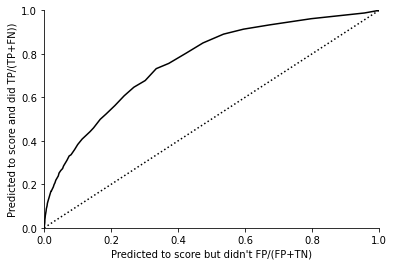

In [57]:
# Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="Goal ~ 1 ", data=shots,
                     family=sm.families.Binomial()).fit()
print("Mcfaddens Rsquared", 1 - test_model.llf / null_model.llf)

# ROC curve
numobs = 100
TP = np.zeros(numobs)
FP = np.zeros(numobs)
TN = np.zeros(numobs)
FN = np.zeros(numobs)

for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for j, shot in shots.iterrows():
        if (shot['Goal'] == 1):
            if (shot['xG'] > threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal'] == 0):
            if (shot['xG'] > threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

fig, ax = plt.subplots()
ax.plot(FP / (FP + TN), TP / (TP + FN), color='black')
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Challenge
1) Create different models for headers and non-headers (as suggested in [Measuring the Effectiveness of Playing Strategies at Soccer, Pollard (1997)](https://www.jstor.org/stable/2988603))!
2) Assign to penalties xG = 0.8!
3) Find out which player had the highest xG in 2017/18 Premier League season!

